## This notebook will show how to use the MNIST dataset with both pyTorch as well as Tensorflow

## pyTorch

In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
# loss function cross entropy and optimize with stocastic gradient boosting algorithm
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
# model training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304225  [   64/60000]
loss: 2.288055  [ 6464/60000]
loss: 2.267038  [12864/60000]
loss: 2.267143  [19264/60000]
loss: 2.248859  [25664/60000]
loss: 2.220971  [32064/60000]
loss: 2.231415  [38464/60000]
loss: 2.199058  [44864/60000]
loss: 2.198331  [51264/60000]
loss: 2.157847  [57664/60000]
Test Error: 
 Accuracy: 42.9%, Avg loss: 2.153965 

Epoch 2
-------------------------------
loss: 2.168658  [   64/60000]
loss: 2.156096  [ 6464/60000]
loss: 2.094773  [12864/60000]
loss: 2.113685  [19264/60000]
loss: 2.064558  [25664/60000]
loss: 2.007096  [32064/60000]
loss: 2.040484  [38464/60000]
loss: 1.961568  [44864/60000]
loss: 1.965715  [51264/60000]
loss: 1.890805  [57664/60000]
Test Error: 
 Accuracy: 57.6%, Avg loss: 1.887317 

Epoch 3
-------------------------------
loss: 1.922558  [   64/60000]
loss: 1.889926  [ 6464/60000]
loss: 1.769892  [12864/60000]
loss: 1.811713  [19264/60000]
loss: 1.710527  [25664/60000]
loss: 1.663496  [32064/600

In [9]:
# save the torch model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
# use the saved model
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [12]:
# model classes
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


Predicted: "Ankle boot", Actual: "Ankle boot"


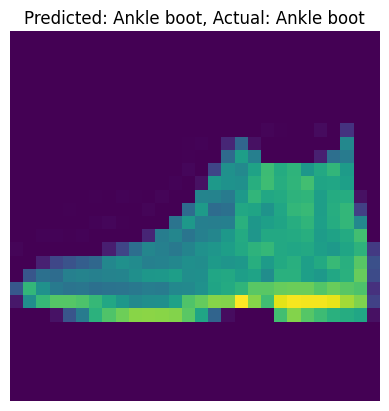

Predicted: "Ankle boot", Actual: "Ankle boot"


In [17]:
# model evaluation
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

    # Plot the image
    plt.imshow(x[0])
    plt.title(f"Predicted: {predicted}, Actual: {actual}")
    plt.axis('off')  # Remove unnecessary axes
    plt.show()

    print(f'Predicted: "{predicted}", Actual: "{actual}"')

## Now with Tensorflow

In [28]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import save_model, load_model

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [20]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [21]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [26]:
num_classes = 10
input_shape = (28, 28, 3)
input_layer = tf.keras.Input(shape=input_shape)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])

model = tf.keras.Sequential([
    # Rescaling layer doesn't need input_tensor in Sequential models
    tf.keras.layers.Rescaling(1./255),  # Normalize input values
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 103ms/step - loss: 1.8131 - sparse_categorical_accuracy: 0.3358 - val_loss: 0.4075 - val_sparse_categorical_accuracy: 0.8768
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 95ms/step - loss: 0.3561 - sparse_categorical_accuracy: 0.8919 - val_loss: 0.2356 - val_sparse_categorical_accuracy: 0.9258
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - loss: 0.2283 - sparse_categorical_accuracy: 0.9308 - val_loss: 0.1860 - val_sparse_categorical_accuracy: 0.9415
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 97ms/step - loss: 0.1684 - sparse_categorical_accuracy: 0.9479 - val_loss: 0.1302 - val_sparse_categorical_accuracy: 0.9590
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - loss: 0.1335 - sparse_categorical_accuracy: 0.9586 - val_loss: 0.1063 - val_sparse_categorical_accuracy: 0.9675
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - loss: 0.1102 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.0954 - val_sparse_categorical_accuracy: 0.9

In [29]:
# Save the model (replace 'my_model.h5' with your desired filename)
save_model(model, 'my_model.h5')

In [30]:
# Load the saved model
loaded_model = load_model('my_model.h5')

In [33]:
# Assuming test_data is a list of tuples (image, label)
x, y = test_data[0][0], test_data[0][1]

# Preprocess the test image if necessary
x = np.array(x, dtype='float32') / 255.0  # Convert to NumPy array and normalize


The `@tf.function` decorator and `jit_compile=True` flag are part of TensorFlow's optimization features, which help accelerate code execution, especially during model inference or training. Here's a breakdown of each:

### **1. `@tf.function` Decorator**
- **Purpose**: Converts a Python function into a TensorFlow computational graph.
- **Explanation**: When you use `@tf.function`, TensorFlow traces the Python function and compiles it into a highly optimized, static computational graph. This graph runs faster than the original Python code because TensorFlow can optimize the graph for performance.
- **Benefits**:
  - **Speed**: Computational graphs are faster because they reduce the overhead of Python’s dynamic interpretation and allow TensorFlow to apply various optimizations.
  - **Compatibility**: Useful for running TensorFlow code on different devices, such as GPUs or TPUs, because the graph abstracts the underlying hardware.
  - **Batch Execution**: Graphs can optimize across batches of operations, reducing computational redundancy.

### **2. `jit_compile=True` in `@tf.function`**
- **Purpose**: Enables Just-In-Time (JIT) compilation using TensorFlow's XLA (Accelerated Linear Algebra) compiler.
- **Explanation**: JIT compilation further optimizes the computational graph by fusing operations together, reducing memory usage, and improving execution speed.
- **Benefits**:
  - **Additional Performance Gains**: By using the XLA compiler, the code can achieve even faster execution times.
  - **Operation Fusion**: JIT compilation can fuse multiple operations into a single kernel (GPU or TPU operation), reducing the number of device-to-host memory transfers.
- **When to Use**:
  - **Model Inference**: Often used when speed is critical during model inference.
  - **Training**: Can also be helpful during training to speed up repeated computations.

### **When to Use Them**
- **`@tf.function`**: Use this decorator when you want to optimize the performance of TensorFlow functions, especially when they contain multiple TensorFlow operations.
- **`jit_compile=True`**: Use this when further optimization is desired, particularly on platforms that support XLA, like certain GPUs or TPUs.


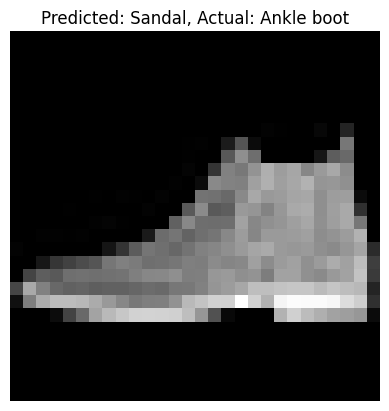

Predicted: "Sandal", Actual: "Ankle boot"


In [41]:
# Enables Just-In-Time (JIT) compilation using TensorFlow's XLA (Accelerated Linear Algebra) compiler.
@tf.function(jit_compile=True)
def predict(model, x):
    return model(x)

# Reshape the input to ensure it has the correct shape: (batch_size, height, width, channels)
x = tf.reshape(x, (28, 28))  # Reshape to 28x28 if necessary
x = tf.expand_dims(x, axis=0)  # Add batch dimension, resulting in (1, 28, 28)
x = tf.expand_dims(x, axis=-1)  # Add channel dimension, resulting in (1, 28, 28, 1)

# Make the prediction
pred = predict(loaded_model, x)

# Get the predicted and actual classes
predicted, actual = classes[tf.argmax(pred[0])], classes[y]

# Plot the image
plt.imshow(x[0, :, :, 0].numpy(), cmap='gray')  # Remove unnecessary dimensions and plot
plt.title(f"Predicted: {predicted}, Actual: {actual}")
plt.axis('off')  # Remove unnecessary axes
plt.show()

print(f'Predicted: "{predicted}", Actual: "{actual}"')
